In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import math
from dwave.system import DWaveSampler
import minorminer as mm
import dwave.inspector

In [2]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='pegasus'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage_system6.1 was selected.


# Create the embedding on the target graph

In [3]:
#create a target graph
T=nx.Graph()
T.add_edges_from(sampler.edgelist)
T.add_nodes_from(sampler.nodelist)

we try to embed Nchains disconnected periodic chains (called rings) of 12 qubits each. We use N=12 qubits chains so that we may compare with the results of the other IBM paper.

In [7]:
#create a source graph
S=nx.Graph()
#spin chain length
Nlen=12
#number of chains
Nchains=100

#define the nodes in base chain
base_nodes=[]
for i in range(Nlen):
    base_nodes.append(i)
base_nodes=np.array(base_nodes)
#generate all the nodes
allnodes=[]
for i in range(Nchains):
    allnodes.append(list(base_nodes+Nlen*i))
#all_nodes is a list of length Nchains, each element is a list of length Nlen

#add nodes to source graph
for i in range(len(allnodes)):
    for j in range(len(allnodes[i])):
        S.add_node(allnodes[i][j])

#define the edges
#loop over all the chains you are trying to embed
for i in range(len(allnodes)):
    #extract current list of sites for this ring
    spinlist=allnodes[i]
    for j in range(len(spinlist)-1):
        #add the nearest neighbor interaction as an edge
        S.add_edge(spinlist[j],spinlist[j+1])
    #add the final edge which completes the periodic chain
    S.add_edge(spinlist[len(spinlist)-1],spinlist[0])

# print the edges, just to see
#print(S.edges)
#you can see the structure of Nlen chains in this list of edges

In [8]:
#use minorminer to embed this graph (it is really Nchain disconnect graphs)
#this may take a while

cond=0
count=0

while (cond==0 and count<1000):
    print(count)

    embedding=mm.find_embedding(S,T)

    #here we make sure that minorminor didn't make any chains 
    biggerthan1=[]
    for value in embedding.values():
        if len(value)>1:
            biggerthan1.append(value)
    #if the embedding has any chains we reject it and try again
    if len(biggerthan1)>0:
        print(len(biggerthan1),"chains")
        cond=0
        count+=1
    if count==999:
        print("reached max iterations")   
    
    #if there are no chains it's a goood embedding
    if len(biggerthan1)==0:
        cond=1
    
print(embedding)

density = len(embedding)/sampler.properties["num_qubits"]

print("density of qubits used: {}".format(density))

0
{0: [4699], 1: [939], 11: [909], 2: [4654], 3: [954], 4: [4610], 5: [1074], 6: [4760], 7: [4759], 8: [789], 9: [788], 10: [4564], 12: [2523], 13: [3568], 23: [3538], 14: [2627], 15: [3403], 16: [3404], 17: [2777], 18: [3464], 19: [3463], 20: [2447], 21: [3523], 22: [2463], 24: [1444], 25: [3652], 35: [1445], 26: [3653], 27: [1578], 28: [3683], 29: [1639], 30: [1640], 31: [3833], 32: [3832], 33: [1504], 34: [3907], 36: [4548], 37: [729], 47: [713], 38: [744], 39: [4533], 40: [4534], 41: [878], 42: [877], 43: [4234], 44: [772], 45: [4323], 46: [712], 48: [2986], 49: [225], 59: [2971], 50: [3030], 51: [150], 52: [3060], 53: [3061], 54: [435], 55: [3167], 56: [450], 57: [3046], 58: [375], 60: [4738], 61: [2484], 71: [2469], 62: [4632], 63: [4631], 64: [2214], 65: [4661], 66: [4660], 67: [2094], 68: [4691], 69: [4692], 70: [4693], 72: [1879], 73: [1880], 83: [3834], 74: [3984], 75: [1730], 76: [3953], 77: [1700], 78: [4044], 79: [1806], 80: [1821], 81: [1820], 82: [3819], 84: [4729], 85: 

setting the J and h values on each used qubit for this particular computation.

In [9]:
jval = -1
hval = -0.3

#set the coupler's interaction to -1 (FM) 
couplers={}
for edge in list(S.edges):
    spin0=edge[0]
    spin1=edge[1]
    qubit0=embedding.get(spin0)[0]
    qubit1=embedding.get(spin1)[0]
    couplers.update({(qubit0,qubit1):jval})

#set the magnetic fields  
hdict={}
#set initial state (+1)
initial={}
for node in list(S.nodes):
    spin0=node
    qubit0=embedding.get(spin0)[0]
    hdict.update({qubit0:hval})
    initial.update({qubit0:1.0})


# info on the sampler properties

For future use.

In [11]:
print("Chosen topology is:")
print(sampler.properties["topology"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {} (in us)".format(sampler.properties["annealing_time_range"]))

max_slope = 1.0/sampler.properties["annealing_time_range"][0]

print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
print("J range: {}".format(sampler.properties["j_range"]))
print("h range: {}".format(sampler.properties["h_range"]))


Chosen topology is:
{'type': 'pegasus', 'shape': [16]}
Maximum anneal-schedule points: 12
Annealing time range: [0.5, 2000.0] (in us)
Maximum slope allowed on this solver is 2.00.
J range: [-1.0, 1.0]
h range: [-4.0, 4.0]


# test run

In [12]:
#test_run
pausetime = 50    
num_reads = 10
sval = 0.3
rev_sch=[[0.0, 1.0], [1/max_slope, sval], [1/max_slope + pausetime, sval],
            [2/max_slope + pausetime, 1.0]]
h_sch = [[0.0, 0.0], [1/max_slope, 1.0], [1/max_slope + pausetime, 1.0],
        [2/max_slope + pausetime, 0.0]]

response = sampler.sample_ising(h=hdict,
J=couplers,
num_reads=num_reads,
anneal_schedule=rev_sch,
initial_state=initial,
h_gain_schedule=h_sch,
answer_mode='raw',
reduce_intersample_correlation=True,
#reinitialize the initial state after reverse annealing                            
reinitialize_state=True)

In [13]:
response.info

{'timing': {'qpu_sampling_time': 9789.8,
  'qpu_anneal_time_per_sample': 51.0,
  'qpu_readout_time_per_sample': 169.66,
  'qpu_access_time': 25709.17,
  'qpu_access_overhead_time': 1920.83,
  'qpu_programming_time': 15919.37,
  'qpu_delay_time_per_sample': 758.32,
  'post_processing_overhead_time': 176.0,
  'total_post_processing_time': 176.0},
 'problem_id': '2010916d-0387-4b50-805c-7b9866b85d96'}

In [75]:
#example of getting a chain record for a given random chain

indice = []
ind = np.random.randint(Nchains) #chain index
for i in range(Nlen*ind, Nlen*(ind+1)):
    indice.append(np.argwhere(np.array(response.variables) == embedding[i])[0][0])

print(indice)

chain_record = np.zeros((num_reads, Nlen))
avg_m = np.zeros(num_reads)
for m in range(num_reads):
    chain_record[m,:] = response.record['sample'][m,indice]
    avg_m[m] = np.mean(chain_record[m,:])

print(np.mean(avg_m))

[422, 670, 444, 687, 426, 693, 698, 429, 428, 661, 440, 669]
0.9833333333333334


In [86]:
avg_m = np.zeros(num_reads*Nchains)
array_fft_z = np.zeros(Nlen)


for j in range(Nchains):
    #this gets the qubit index for that j-th chain
    indice = []
    for i in range(Nlen*j, Nlen*(j+1)):
        indice.append(np.argwhere(np.array(response.variables) == embedding[i])[0][0])
    #the indice list is all the QPU-native qubit index where we but retrieve info.
    
    chain_record = np.zeros((num_reads, Nlen))
    #this will store the data for each read (total of num_reads), for each site in the chain (total of Nlen)
    for m in range(num_reads):
        chain_record[m,:] = response.record['sample'][m,indice]
        #chain_record[m,:] is the m-th Z measurement of this chain j
        fft_z = np.fft.fft(chain_record[m,:])
        array_fft_z += np.sqrt((fft_z.real)**2 + (fft_z.imag)**2)
        avg_m[j*num_reads + m] = np.mean(chain_record[m,:])

array_fft_z = array_fft_z/(num_reads*Nchains)


This is an important function: it allows to reconstruct the chain's data from the full data itself.

In [92]:
print('<|\sigma_z (q)|^2> = {}'.format(array_fft_z))
print('avg M_z',np.mean(avg_m))
print('var M_z',np.var(avg_m))

<|\sigma_z (q)|^2> = [11.98        0.01869213  0.0154641   0.012       0.014       0.01379315
  0.012       0.01379315  0.014       0.012       0.0154641   0.01869213]
avg M_z 0.9983333333333333
var M_z 0.0006083333333333336


# doing the run itself

note: parameters for the IBM-spectroscopy paper

J=1, h=0.3, g=0.25, t=30, dt=0.4

Time steps = 75
Circuits = 76

Shots = 8192

For the D-Wave machine, we have that at s=0.357, A(s)/B(s) = g/J = 0.25.
We also have s=0.3, A(s)/B(s) = g/J ~ 0.5.

In [119]:
#note that the schedules have been adapted, 
# so that none has a slope lager than the max slope. 
#this is mostly limited by the h_gain_schedule

def run_specific_pause(sval, jval, hval, pausetime, num_reads, check_time):     

    #set the coupler's interaction to -1 (FM) 
    couplers={}
    for edge in list(S.edges):
        spin0=edge[0]
        spin1=edge[1]
        qubit0=embedding.get(spin0)[0]
        qubit1=embedding.get(spin1)[0]
        couplers.update({(qubit0,qubit1):jval})

    #set the magnetic fields  
    hdict={}
    #set initial state (+1)
    initial={}
    for node in list(S.nodes):
        spin0=node
        qubit0=embedding.get(spin0)[0]
        hdict.update({qubit0:hval})
        initial.update({qubit0:1.0})


    #reverse anneal schedule (change as needed. but, must start with [0,1] and end at [tf,1])
    rev_sch=[[0.0, 1.0], [1/max_slope, sval], [1/max_slope + pausetime, sval],
                [2/max_slope + pausetime, 1.0]]
    h_sch = [[0.0, 0.0], [1/max_slope, 1.0], [1/max_slope + pausetime, 1.0],
            [2/max_slope + pausetime, 0.0]]

    #print("reverse anneal schedule:")
    #print(rev_sch)
    #print("\n")
    avg_m = np.zeros(num_reads*Nchains)
    array_fft_z = np.zeros(Nlen)

    if check_time:
        #print("pausetime = {}".format(pausetime))
        estimated_runtime = sampler.solver.estimate_qpu_access_time(num_qubits = len(initial), h=hdict,
            J=couplers,
            num_reads=num_reads,
            anneal_schedule=rev_sch,
            initial_state=initial,
            h_gain_schedule=h_sch,
            answer_mode='raw',
            reduce_intersample_correlation=True,
            #reinitialize the initial state after reverse annealing                            
            reinitialize_state=True)    
        timing = estimated_runtime/10**6
    else:
        response = sampler.sample_ising(h=hdict,
        J=couplers,
        num_reads=num_reads,
        anneal_schedule=rev_sch,
        initial_state=initial,
        h_gain_schedule=h_sch,
        answer_mode='raw',
        reduce_intersample_correlation=True,
        #reinitialize the initial state after reverse annealing                            
        reinitialize_state=True)

        for j in range(Nchains):
            #this gets the qubit index for that j-th chain
            indice = []
            for i in range(Nlen*j, Nlen*(j+1)):
                indice.append(np.argwhere(np.array(response.variables) == embedding[i])[0][0])
            #the indice list is all the QPU-native qubit index where we but retrieve info.
            
            chain_record = np.zeros((num_reads, Nlen))
            #this will store the data for each read (total of num_reads), for each site in the chain (total of Nlen)
            for m in range(num_reads):
                chain_record[m,:] = response.record['sample'][m,indice]
                #chain_record[m,:] is the m-th Z measurement of this chain j
                fft_z = np.fft.fft(chain_record[m,:])
                array_fft_z += np.sqrt((fft_z.real)**2 + (fft_z.imag)**2)
                avg_m[j*num_reads + m] = np.mean(chain_record[m,:])

        array_fft_z = array_fft_z/(num_reads*Nchains)
        timing = response.info['timing']['qpu_access_time']/10**6 

    return avg_m, array_fft_z, timing

    

# first, time estimate

In [120]:
#set vals

sval=0.3
#pausetime = 15
pause_list = np.linspace(1, 40, 2*39+1) 
num_reads = 50

#time estimate!!!
total_time = 0
for j in range(len(pause_list)):
    avg_m, array_fft, timing = run_specific_pause(sval, -1, -0.1, pause_list[j], num_reads, True)
    total_time += timing
    print("Pause of {}, Timing of {:.3f} s on {}".format(pause_list[j], timing, sampler.solver.name)) 

print('\n')
print("Total time is {:.3f} s".format(total_time)) 

#for j in range(len(pause_list)):
#    mag_vals[j], mag_errs[j] = run_specific_pause(sval, pause_list[j], num_reads, False)
#    print("done with s={}".format(pause_list[j]))
#    print("\n")


Pause of 1.0, Timing of 0.050 s on Advantage_system6.1
Pause of 1.5, Timing of 0.050 s on Advantage_system6.1
Pause of 2.0, Timing of 0.051 s on Advantage_system6.1
Pause of 2.5, Timing of 0.051 s on Advantage_system6.1
Pause of 3.0, Timing of 0.051 s on Advantage_system6.1
Pause of 3.5, Timing of 0.051 s on Advantage_system6.1
Pause of 4.0, Timing of 0.051 s on Advantage_system6.1
Pause of 4.5, Timing of 0.051 s on Advantage_system6.1
Pause of 5.0, Timing of 0.051 s on Advantage_system6.1
Pause of 5.5, Timing of 0.052 s on Advantage_system6.1
Pause of 6.0, Timing of 0.052 s on Advantage_system6.1
Pause of 6.5, Timing of 0.052 s on Advantage_system6.1
Pause of 7.0, Timing of 0.052 s on Advantage_system6.1
Pause of 7.5, Timing of 0.052 s on Advantage_system6.1
Pause of 8.0, Timing of 0.052 s on Advantage_system6.1
Pause of 8.5, Timing of 0.052 s on Advantage_system6.1
Pause of 9.0, Timing of 0.053 s on Advantage_system6.1
Pause of 9.5, Timing of 0.053 s on Advantage_system6.1
Pause of 1

# Full run

In [121]:
#set vals

sval=0.3
jval = -1.0
hval = 0.1
#pausetime = 15
pause_list = np.linspace(1, 40, 2*39+1) 
num_reads = 50

#time estimate!!!
total_time = 0
sigmaz_avg = np.zeros(len(pause_list))
sigmaz_err = np.zeros(len(pause_list))
sigmaz_FFT = np.zeros((len(pause_list), Nlen))

for j in range(len(pause_list)):
    avg_m, array_fft, timing = run_specific_pause(sval, jval, hval, pause_list[j], num_reads, False)
    total_time += timing
    sigmaz_avg[j] = np.mean(avg_m)
    sigmaz_err[j] = np.std(avg_m)
    sigmaz_FFT[j, :] = array_fft
    print("--Done-- Pause of {}, Timing of {:.3f} s".format(pause_list[j], timing)) 

print('\n')
print("Total time is {:.3f} s".format(total_time)) 

#for j in range(len(pause_list)):
#    mag_vals[j], mag_errs[j] = run_specific_pause(sval, pause_list[j], num_reads, False)
#    print("done with s={}".format(pause_list[j]))
#    print("\n")


--Done-- Pause of 1.0, Timing of 0.051 s
--Done-- Pause of 1.5, Timing of 0.051 s
--Done-- Pause of 2.0, Timing of 0.051 s
--Done-- Pause of 2.5, Timing of 0.051 s
--Done-- Pause of 3.0, Timing of 0.051 s
--Done-- Pause of 3.5, Timing of 0.052 s
--Done-- Pause of 4.0, Timing of 0.052 s
--Done-- Pause of 4.5, Timing of 0.052 s
--Done-- Pause of 5.0, Timing of 0.052 s
--Done-- Pause of 5.5, Timing of 0.052 s
--Done-- Pause of 6.0, Timing of 0.052 s
--Done-- Pause of 6.5, Timing of 0.052 s
--Done-- Pause of 7.0, Timing of 0.053 s
--Done-- Pause of 7.5, Timing of 0.053 s
--Done-- Pause of 8.0, Timing of 0.053 s
--Done-- Pause of 8.5, Timing of 0.053 s
--Done-- Pause of 9.0, Timing of 0.053 s
--Done-- Pause of 9.5, Timing of 0.053 s
--Done-- Pause of 10.0, Timing of 0.053 s
--Done-- Pause of 10.5, Timing of 0.054 s
--Done-- Pause of 11.0, Timing of 0.054 s
--Done-- Pause of 11.5, Timing of 0.054 s
--Done-- Pause of 12.0, Timing of 0.054 s
--Done-- Pause of 12.5, Timing of 0.054 s
--Done-- P

In [122]:
# store arrays
save_sigma_avg_err = np.array([sigmaz_avg, sigmaz_err])
np.save('data/sigma_s={}_h={}.npy'.format(sval, hval), save_sigma_avg_err)
np.save('data/FFT_sigma_s={}_h={}.npy'.format(sval, hval), sigmaz_FFT)

#use np.load to load the array

# Plotting

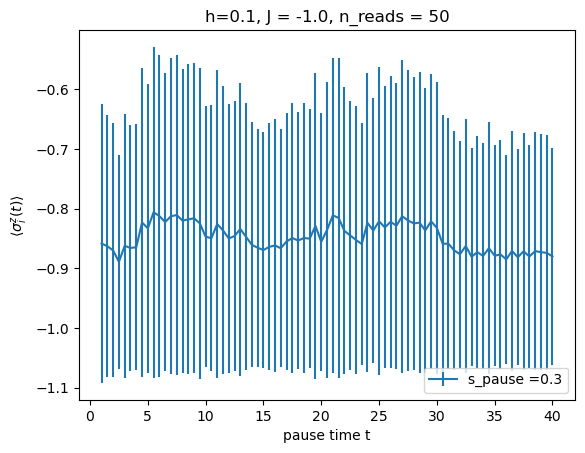

In [123]:

fig = plt.figure()
x = pause_list
y = sigmaz_avg
yerr = sigmaz_err**2

plt.errorbar(x, y, yerr=yerr, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.ylabel(r"$\langle \sigma^z_i (t) \rangle$")
plt.xlabel("pause time t")
plt.legend(loc='lower right')
#plt.ylim([0.99, 1.01])

#note - BIIIIG error bars!

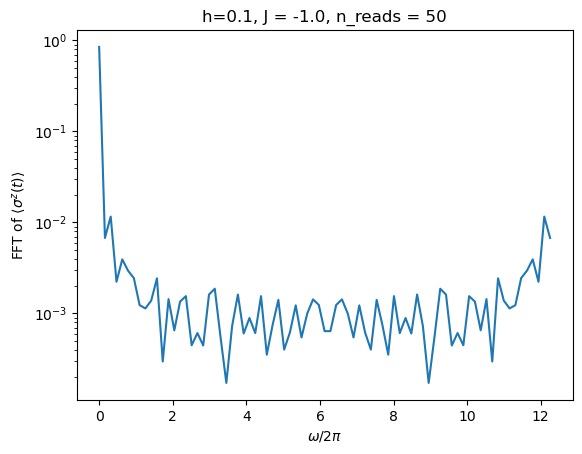

In [124]:
fftvals = np.abs(np.fft.fft(sigmaz_avg, norm='forward'))
y = fftvals
x = np.arange(0, len(sigmaz_avg), 1)*2*np.pi/pause_list[-1]
plt.plot(x, y, label='s_pause ={}'.format(sval))
plt.title('h={}, J = {}, n_reads = {}'.format(hval, jval, num_reads))
plt.yscale('log')
plt.ylabel(r"FFT of $\langle  \sigma^z (t)\rangle$")
plt.xlabel(r"$\omega/2\pi$");
#plt.xlim((0,6))

Frequency spectra needs to be cut in half. Also, it is too dominated by $\omega = 0$ signal - need to go to $\sigma^x$ measurement??

**Some conclusions:**
- Definitely need more measurements. At the moment, this is 50x100 chains. It would be so much better to have 500x100 chains. The noise would go down. Variance it too high right now.
- Each run with those parameters will take about 50 seconds of QPU access. If, at the end of the month, we have remaining access, we will try it for ~4 parameters of g,h
- It is also unclear whether something more happens at larger times!
- Measuring in other basis would be interesting - how can it be approximated?

# Measure in the X and Y basis

Of course we measure the Z basis, but we can post-process it to "measure" in X and Y. See Chris' note. Works for small chains ($N < 20$). Need to decompose results array into 300 arrays of results for a given chain. It is highly possible that we can only observe the oscillations in the $X$ or $Y$ basis.

See Notebook!, can use qutip to get a tensor product for the $Z \times I \times I ...$ operators that are then sandwiched between $|\Psi>_z$. 

For this, you need the raw data-file, no spin-reversal transformation, and then extract the 12-bit strings one by one in a different file. Then, run anoter program to extract a dict of how often some specific bitstrings (for $N=12$, there are $2^{12}$ of them) appear.

# h-gain schedule

We can set an h-gain schedule, so that, in the reverse annealing, we specifiy $h(t) = [[0,0], [(1-s),h], [(1-s)+t_{p}, h], [2*(1-s) + t_p, 0]]$. Therefore, the time evolution after the quench is the only one that has a term with $g \neq h \neq 0$. At each ends on the reverse annealing steps, the Hamiltonian is only $H = -J \sum_{i=1}^{N-1} \sigma^z_i \sigma^z_{i+1}$.

See this https://journals.aps.org/prresearch/pdf/10.1103/PhysRevResearch.5.013224 for some insight